# 9. Simulation

**Objective:**

Testing and comparison of the performance of various methods of Gaussian process feature selection for sparse datasets. 

**Models:**

1. Standard optimization

2. ARD kernel optimization

3. Lasso feature selection before optimization
    - $\lambda$ selected via cross-validation
4. Lasso feature selection before ARD kernel optimization
    - $\lambda$ selected via cross-validation
5. L1-penalized optimization
    - $\lambda$ selected via cross-validation
    - Includes added thresholding


**Metrics:**

The following metrics will be used to compare the performance of the 5 models. 

- Estimation error of coefficients $$\varepsilon_{\beta} = \|\beta - \hat{\beta}\|_2$$
- Training and testing Prediction error $$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(y_i - \hat{y_i}\right)^2}$$
- Coefficient Selection:
    - Precision: Selected coefficients / Active Coefficients
    - Recall:
    - True Positive Rate
    - False Positive Rate

- Computation Time:
    - Total runtime for model tuning, fitting, and prediction, measured in seconds.
    - Runtime for individual phases of tuning, fitting, and prediction, measured in seconds.

### Testing on one dataset

In [201]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gpflow as gpf
import json
import tensorflow as tf
import time

from sklearn.linear_model import LinearRegression, LassoLarsCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Define a class


In [391]:
from tracemalloc import start


class GPFeatureSelect:

    def __init__(self, model_type = 'std', cv = 5):
        self.model_type = model_type
        self.cv = cv

        self.scaler = StandardScaler()
        self.scaledX = None
        self.selected_features = None
        self.lasso_model = None
        self.lambda_val = None
        self.beta_hat = None
        self.runtime = None
        self.tunetime = None
        self.fittime = None
        self.predicttime = None
        self.opt = gpf.optimizers.Scipy()
        
    def training_loss_lasso(self):
        base_loss = self.gp_model.training_loss()
        l1_penalty = self.lambda_val * tf.reduce_sum(tf.abs(self.gp_model.mean_function.A))
        total_loss = base_loss + l1_penalty
        return total_loss

    def cv_lasso_lars(self, X, y):
        tune_start = time.time()
        if self.model_type in ['lasso_std', 'lasso_ard']:
            las = LassoLarsCV(cv = self.cv)
            las.fit(X, y.ravel())
            mask = np.abs(las.coef_) > 1e-4
            self.selected_features = np.where(mask)[0]
            self.beta_hat = las.coef_
            self.lasso_model = las
            self.lambda_val = las.alpha_
            self.tunetime = time.time() - tune_start
            return X[:, self.selected_features]
            
        else:
            raise ValueError("cv_lasso_lars called on non-lasso model")

    def tune_lambda(self, X, y):
        start_tunetime = time.time()
        def run_cv(lambda_grid):
            best_lbda = None
            best_rmse = np.inf
            lambda_rmse_pairs = []


            for l in lambda_grid:
                rmses = []
                kf = KFold(n_splits=self.cv, shuffle=True, random_state=22)
                for train_index, val_index in kf.split(X):
                    X_train, X_val = X[train_index], X[val_index]
                    y_train, y_val = y[train_index], y[val_index]

                    self.init_ard_gp_mod(X_train, y_train)
                    self.lambda_val = l
                    self.opt.minimize(
                        lambda: self.training_loss_lasso(),
                        self.gp_model.trainable_variables
                    )

                    y_pred = self.gp_model.predict_f(X_val)[0].numpy().flatten()
                    rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))
                    rmses.append(rmse)

                avg_rmse = np.mean(rmses)
                lambda_rmse_pairs.append((l, avg_rmse))

                #print('\nRMSE for this fold: ', avg_rmse)

                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_lbda = l
            self.tunetime = time.time() - start_tunetime
            return best_lbda, lambda_rmse_pairs

        coarse_grid = np.logspace(-1, 1, 10)
        #print("Coarse grid:", coarse_grid)

        best_coarse, coarse_log = run_cv(coarse_grid)
        
        #print("Best coarse λ:", best_coarse)
        # lambdas, rmses = zip(*coarse_log)
        # plt.figure(figsize=(6, 4))
        # plt.plot(np.log10(lambdas), rmses, marker='o', label='Validation RMSE')
        # plt.xlabel("log10(lambda)")
        # plt.ylabel("Validation RMSE")
        # plt.title("Lambda vs RMSE")
        # plt.grid(True)
        # plt.legend()
        # plt.show()
  
        #return best_coarse

        fine_grid = np.linspace(best_coarse * 0.5, best_coarse * 1.5, 6)
        best_fine, fine_log = run_cv(fine_grid)
        self.lambda_val = best_fine
        self.lambda_rmse_log = coarse_log + fine_log
        return best_fine

        
    def init_gp_mod(self, X, y):
        y = np.asarray(y).reshape(-1, 1)
        m = X.shape[1]
        A_init = tf.zeros((m, 1), dtype=tf.float64)
        b_init = tf.zeros((1,), dtype=tf.float64)

        kernel = gpf.kernels.SquaredExponential(lengthscales=1)
        likelihood = gpf.likelihoods.Gaussian()
        mean_function = gpf.mean_functions.Linear(A=A_init, b = b_init) 

        self.gp_model = gpf.models.GPR(data = (X, y.reshape(-1,1)), kernel = kernel, likelihood = likelihood, mean_function = mean_function)

    def init_ard_gp_mod(self, X, y):
        y = np.asarray(y).reshape(-1, 1)
        m = X.shape[1]
        A_init = tf.zeros((m, 1), dtype=tf.float64)
        b_init = tf.zeros((1,), dtype=tf.float64)

        kernel = gpf.kernels.SquaredExponential(lengthscales=np.ones(m))
        likelihood = gpf.likelihoods.Gaussian()
        mean_function = gpf.mean_functions.Linear(A=A_init, b = b_init) 

        self.gp_model = gpf.models.GPR(data = (X, y.reshape(-1,1)), kernel = kernel, likelihood = likelihood, mean_function = mean_function)

    def fit(self, X, y):
        fit_start_time = time.time()

        X = self.scaler.fit_transform(X)
        y = np.asarray(y).reshape(-1,1)

        if self.model_type == 'std':
            self.init_gp_mod(X, y)
            self.opt.minimize(
                self.gp_model.training_loss,
                self.gp_model.trainable_variables)
            self.beta_hat = self.gp_model.mean_function.A.numpy().flatten()

        elif self.model_type =='ard':
            self.init_ard_gp_mod(X, y)
            self.opt.minimize(
                self.gp_model.training_loss,
                self.gp_model.trainable_variables)
            self.beta_hat = self.gp_model.mean_function.A.numpy().flatten()

        elif self.model_type =='lasso_std':
            reducedX = self.cv_lasso_lars(X,y)
            self.init_gp_mod(reducedX, y)
            self.opt.minimize(
                self.gp_model.training_loss,
                self.gp_model.trainable_variables)
            self.beta_hat = self.gp_model.mean_function.A.numpy().flatten()
            
        elif self.model_type == 'lasso_ard':
            reducedX = self.cv_lasso_lars(X,y)
            self.init_ard_gp_mod(reducedX, y)
            self.opt.minimize(
                self.gp_model.training_loss,
                self.gp_model.trainable_variables)
            self.beta_hat = self.gp_model.mean_function.A.numpy().flatten()

        elif self.model_type == 'l1_gp': 
            if self.lambda_val is None:
                self.tune_lambda(X,y)

            # start by training on all features
            self.init_ard_gp_mod(X, y)
            self.opt.minimize(
                lambda: self.training_loss_lasso(),
                self.gp_model.trainable_variables   
            )

            # threshold coefficients to select features
            beta_full = self.gp_model.mean_function.A.numpy().flatten()

            threshold = 0.05 * np.max(np.abs(beta_full)) # using 5% of max magnitude
            mask = np.abs(beta_full) > threshold

            if np.sum(mask) == 0: # keep at least one feature
                mask[np.argmax(np.abs(beta_full))] = True

            beta_full[~mask] = 0.0
            self.selected_features = np.where(mask)[0]
            self.beta_hat = beta_full[mask]

            Anew = self.beta_hat.reshape(-1,1)
            b_same = self.gp_model.mean_function.b
            assert Anew.shape[0] == X[:, self.selected_features].shape[1], (
                f"Anew.shape = {Anew.shape}, X[:, selected_features].shape = {X[:, self.selected_features].shape}")

            self.gp_model.mean_function = gpf.mean_functions.Linear(A=Anew, b = b_same)
            self.gp_model.data = (X[:, self.selected_features], y)

            old_ls = self.gp_model.kernel.lengthscales.numpy()
            new_ls = old_ls[self.selected_features]
            self.gp_model.kernel = gpf.kernels.SquaredExponential(
                lengthscales=new_ls, 
                active_dims=list(range(len(self.selected_features))))
            
            if len(self.selected_features) == 0:
                print ('No features selected after thresholding')
                return
            
        else:
            raise ValueError("Unknown model type")
        
        self.fittime = (time.time() - fit_start_time - self.tunetime) if self.tunetime is not None else (time.time() - fit_start_time)
        
    def predict(self, X, istest=False):
        if istest:
            predict_start = time.time()

        X = self.scaler.transform(X)

        if self.selected_features is not None:
            if isinstance(X, pd.DataFrame):
                X = X.iloc[:, self.selected_features]
            else:
                X = X[:, self.selected_features]

        X = np.asarray(X)

        mean, _ = self.gp_model.predict_f(X)

        if istest:
            self.predicttime = time.time() - predict_start
        return mean.numpy().flatten()
    
    def get_metrics(self, Xtrain, ytrain, Xtest, ytest, beta_true=None):
        ytrain_pred = self.predict(Xtrain, istest = False)
        train_rmse = np.sqrt(np.mean((ytrain - ytrain_pred) ** 2))
        
        ytest_pred = self.predict(Xtest, istest = True)
        test_rmse = np.sqrt(np.mean((ytest - ytest_pred) ** 2))

        beta_error = None
        precision = None
        recall = None

        if beta_true is not None and self.beta_hat is not None:

            beta_hat_full = np.zeros(len(beta_true))
            if self.selected_features is not None:
                beta_hat_full[self.selected_features] = self.beta_hat
            else:
                beta_hat_full = self.beta_hat   

            beta_true_bin = (beta_true != 0).astype(int)
            beta_hat_full_bin = (beta_hat_full != 0).astype(int)
            beta_error = np.sqrt(np.mean((beta_true_bin - beta_hat_full_bin) ** 2))

            [tn, fp, fn, tp] = confusion_matrix(beta_true_bin, beta_hat_full_bin, labels = [0, 1]).ravel()
                    
            if (tp + fp) == 0:
                precision = 0.0
            else:
                precision = tp / (tp + fp)

            if (tp + fn) == 0:
                recall = 0.0
            else:
                recall = tp / (tp + fn)
            
        self.runtime = (self.fittime or 0) + (self.predicttime or 0) + (self.tunetime or 0)
        
        return {
            'selected features': self.selected_features if self.selected_features is not None else 'All features',
            'precision': precision,
            'recall': recall,
            'training rmse': train_rmse.round(4),
            'testing rmse': test_rmse.round(4),
            'beta_error': beta_error.round(4),
            'tune time': round(self.tunetime, 4) if self.tunetime is not None else None,
            'fit time': round(self.fittime, 4) if self.fittime is not None else None,
            'prediction time (test)': round(self.predicttime, 4) if self.predicttime is not None else None,
            'total runtime': round(self.runtime, 4) if self.runtime is not None else None,
            'lambda': self.lambda_val.round(4) if self.lambda_val is not None else None
        }
    

## Testing each model using one simulated dataset

In [362]:
data_path = 'Simulation Datasets/N500_AP10_noise0.1_seed49/N500_AP10_noise0.1_seed49_data.csv'
meta_path = 'Simulation Datasets/N500_AP10_noise0.1_seed49/N500_AP10_noise0.1_seed49_meta.json'

In [363]:
with open(meta_path, 'r') as f:
    meta = json.load(f)

beta_true = np.array(meta['beta'])

beta_true

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        4.02142514, -3.616977  ,  0.        ,  0.        ,  0.        ,
        0.        , -0.80053015,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [364]:
beta_true

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        4.02142514, -3.616977  ,  0.        ,  0.        ,  0.        ,
        0.        , -0.80053015,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

{'n': 500, 'active_prop': 0.1, 'noise_constant': 0.1, 'seed': 49, 'active_indices': [11, 16, 10], 'gp_features': [16, 11, 10], 'lengthscales': [2.0635919017553026, 0.7206373204442309, 2.2497101381425093], 'beta': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.021425142366843, -3.616976996191823, 0.0, 0.0, 0.0, 0.0, -0.8005301510478198, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
2.613121269939139


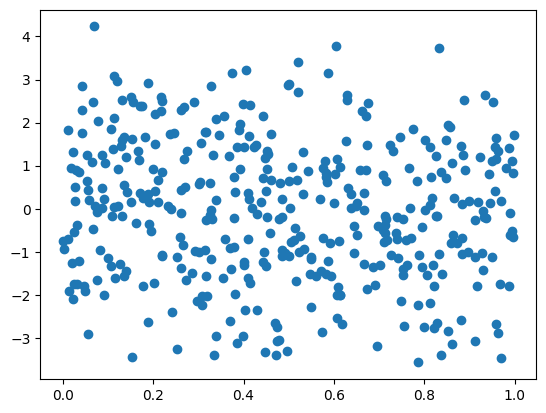

In [365]:
dat = pd.read_csv(data_path)
dat.head()
X = dat.drop(columns = 'y')
y = dat['y']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state = 22)

print(meta)

import matplotlib.pyplot as plt
plt.scatter(Xtrain.iloc[:, 16], ytrain)

print(np.var(ytrain))

In [366]:
mod1_std = GPFeatureSelect(model_type='std')
mod1_std.fit(Xtrain,ytrain)
mod1_std.get_metrics(Xtrain, ytrain, Xtest, ytest, beta_true)

{'selected features': 'All features',
 'precision': 0.1,
 'recall': 1.0,
 'training rmse': 0.2644,
 'testing rmse': 0.5391,
 'beta_error': 0.9487,
 'tune time': None,
 'fit time': 0.2957,
 'prediction time (test)': 0.0308,
 'total runtime': 0.3265,
 'lambda': None}

In [367]:
mod2_ard = GPFeatureSelect(model_type = 'ard')
mod2_ard.fit(Xtrain, ytrain)
mod2_ard.get_metrics(Xtrain, ytrain, Xtest, ytest, beta_true)

{'selected features': 'All features',
 'precision': 0.1,
 'recall': 1.0,
 'training rmse': 0.2644,
 'testing rmse': 0.5391,
 'beta_error': 0.9487,
 'tune time': None,
 'fit time': 0.453,
 'prediction time (test)': 0.017,
 'total runtime': 0.47,
 'lambda': None}

In [368]:
mod3_las_std = GPFeatureSelect(model_type = 'lasso_std')
mod3_las_std.fit(Xtrain, ytrain)
mod3_las_std.get_metrics(Xtrain, ytrain, Xtest, ytest, beta_true)


{'selected features': array([10, 11, 16, 29]),
 'precision': 0.75,
 'recall': 1.0,
 'training rmse': 0.54,
 'testing rmse': 0.5279,
 'beta_error': 0.1826,
 'tune time': 0.0249,
 'fit time': 0.7822,
 'prediction time (test)': 0.0175,
 'total runtime': 0.8246,
 'lambda': 0.0412}

In [369]:
mod3_las_std.selected_features

array([10, 11, 16, 29])

In [370]:
print(mod3_las_std.lambda_val)

0.041155711176584994


In [371]:
mod4_las_ard = GPFeatureSelect(model_type = 'lasso_ard')
mod4_las_ard.fit(Xtrain, ytrain)
mod4_las_ard.get_metrics(Xtrain, ytrain, Xtest, ytest, beta_true)

{'selected features': array([10, 11, 16, 29]),
 'precision': 0.75,
 'recall': 1.0,
 'training rmse': 0.54,
 'testing rmse': 0.5279,
 'beta_error': 0.1826,
 'tune time': 0.0539,
 'fit time': 0.6886,
 'prediction time (test)': 0.0169,
 'total runtime': 0.7594,
 'lambda': 0.0412}

In [372]:
mod4_las_ard.selected_features

array([10, 11, 16, 29])

In [373]:
print(mod4_las_ard.lambda_val)

0.041155711176584994


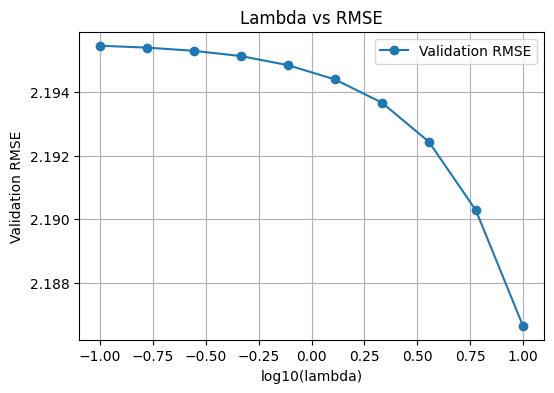

In [392]:
mod5_l1_gp = GPFeatureSelect(model_type = 'l1_gp')
mod5_l1_gp.fit(Xtrain, ytrain)


In [396]:
mod5_l1_gp.selected_features

array([10, 11, 16])

In [400]:
mod5_l1_gp.predict(Xtest, istest = True)

array([-3.05161511, -0.29163842, -0.76778114,  0.61676255, -1.23360463,
        2.19410302, -1.955187  ,  1.18775723, -1.19468915, -0.62537189,
        0.57226549,  1.18055583,  1.78476621, -1.78326795, -0.41404656,
        2.20422969,  0.22842057, -1.21168425,  1.07442479, -1.0456483 ,
        0.43151402,  1.76922304,  0.92567802, -1.34983847, -1.33274814,
       -3.52177933, -0.12394607,  1.66157482, -0.95874992, -1.06193972,
        0.92891007, -1.88721341,  0.99256608, -0.6388118 , -1.58970446,
       -2.38110557, -2.97235352, -0.903579  , -0.46738879, -0.16737028,
        0.42219781, -0.08901496,  0.72149039, -0.05114981, -0.41135642,
       -1.02801363, -0.96986906, -2.49408942,  1.32810341,  1.3180216 ,
        0.2340293 ,  1.24354628, -1.06277427, -0.16688872, -2.75119045,
       -2.83732142,  1.77471469,  1.8945785 , -1.10643854,  2.0474717 ,
        2.43270725, -2.58766531,  0.32532528, -1.73798283,  1.46944939,
        1.07241355, -1.20233077,  1.33477875,  2.99268391, -1.20

In [399]:
mod5_l1_gp.get_metrics(Xtrain, ytrain, Xtest, ytest, beta_true)

{'selected features': array([10, 11, 16]),
 'precision': 1.0,
 'recall': 1.0,
 'training rmse': 0.487,
 'testing rmse': 0.564,
 'beta_error': 0.0,
 'tune time': 40.6464,
 'fit time': 0.8607,
 'prediction time (test)': 0.0168,
 'total runtime': 41.5239,
 'lambda': 15.0}

In [398]:
mod5_l1_gp.beta_hat

array([ 1.15026901, -0.80841013, -0.16597666])

In [397]:
print(mod5_l1_gp.lambda_val) # ask about this

15.0
